In [24]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import librosa
import librosa.display
import soundfile as sf
from tqdm import tqdm

In [2]:
"""SR = Sample Rate"""

DATASET_PATH = "./data" 
SR = 16000 
N_MFCC = 13
N_MELS = 128
HOP_LENGTH = 512

DURATION = None

In [3]:
def load_audio(path, sr=SR, mono=True, trim_silence=True, duration=DURATION):
    """Step 1: Load audio with librosa """
    y, orig_sr = librosa.load(path, sr=None, mono=mono)

    """ Step 2: Resample if need. if the file sample reate is different from target sample rate then reshape the sample
    the sr rate we need is 16"""
    if orig_sr != sr:
        y = librosa.resample(y, orig_sr=orig_sr, target_sr=sr)
    
    """ Step 3: Trim silence part at start and end of the audio  """
    if trim_silence:
        y, _ = librosa.effects.trim(y, top_db=20)
    """Step 4: Ensure all audio has same length """
    if duration is not None:
        target_len = int(sr * duration)
        if len(y) > target_len:
            y = y[:target_len] 
        else:
            y = np.pad(y, (0, max(0, target_len - len(y))), mode='constant') 
    """Step 5: Normalized Amplitude """
    max_amp = np.max(np.abs(y)) if len(y) > 0 else 1.0
    if max_amp > 0:
        y = 0.99 * y / max_amp
    
    return y


In [4]:
def save_wav(y, out_path, sr=SR):
    sf.write(out_path, y, sr)

In [5]:
"""This function takes audio, computes MFCCs, and gives you a compact representation of the sound"""
def extract_mfcc(y, sr=SR, n_mfcc=N_MFCC, hop_length=HOP_LENGTH):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length)
    return mfcc


In [6]:
"""Returns the Mel spectrogram in dB, ready for analysis or as input to a neural network."""
def extract_melspectrogram(y, sr=SR, n_mels=N_MELS, hop_length=HOP_LENGTH):
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, hop_length=hop_length)
    S_db = librosa.power_to_db(S, ref=np.max)
    return S_db


In [7]:
def extract_chroma(y, sr=SR, hop_length=HOP_LENGTH):
    chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=hop_length)
    return chroma


In [9]:
RAVDESS_EMOTION_MAP = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

In [10]:
def parse_ravdess_label(filename):
    base = os.path.basename(filename)
    parts = base.replace('.wav','').split('-')
    # defensive
    if len(parts) < 3:
        return None
    emotion_code = parts[2]
    return RAVDESS_EMOTION_MAP.get(emotion_code, 'unknown')


In [11]:
def build_file_dataframe(dataset_path):
    pattern = os.path.join(dataset_path, '**', '*.wav')
    files = glob.glob(pattern, recursive=True)
    rows = []
    for f in files:
        lbl = parse_ravdess_label(f)
        if lbl is None:
            continue
        rows.append({'path': f, 'label': lbl})
    df = pd.DataFrame(rows)
    return df

In [12]:
def plot_waveform_and_spectrogram(y, sr=SR, title=None):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    librosa.display.waveshow(y, sr=sr)
    plt.title('Waveform' + (f' - {title}' if title else ''))
    plt.subplot(1,2,2)
    S_db = extract_melspectrogram(y, sr=sr)
    librosa.display.specshow(S_db, sr=sr, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel')
    plt.title('Mel Spectrogram')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

In [13]:
from scipy.stats import skew, kurtosis

def mfcc_stats(mfcc):
    # mfcc shape: (n_mfcc, T)
    features = []
    features.extend(np.mean(mfcc, axis=1))
    features.extend(np.std(mfcc, axis=1))
    features.extend(skew(mfcc, axis=1))
    features.extend(kurtosis(mfcc, axis=1))
    return np.array(features)


In [14]:
def build_ml_dataset(df, sr=SR):
    X = []
    y = []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        path = row['path']
        label = row['label']
        y_arr = load_audio(path, sr=sr)
        if len(y_arr) == 0:
            continue
        mfcc = extract_mfcc(y_arr, sr=sr)
        feat = mfcc_stats(mfcc)
        X.append(feat)
        y.append(label)
    X = np.vstack(X)
    y = np.array(y)
    return X, y

In [20]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [15]:
def run_baseline_random_forest(X, y, test_size=0.2, random_state=42):
    le = LabelEncoder()
    y_enc = le.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=test_size, stratify=y_enc, random_state=random_state)

    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)

    clf = RandomForestClassifier(n_estimators=200, random_state=random_state)
    clf.fit(X_train_s, y_train)
    y_pred = clf.predict(X_test_s)

    acc = accuracy_score(y_test, y_pred)
    print(f"Baseline RandomForest accuracy: {acc:.4f}")
    print("Classification report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix - RandomForest')
    plt.show()

    return clf, scaler, le

In [16]:
def make_mel_image(y, sr=SR, n_mels=N_MELS, hop_length=HOP_LENGTH, out_size=(128,128)):
    S_db = extract_melspectrogram(y, sr=sr, n_mels=n_mels, hop_length=hop_length)
    # S_db shape is (n_mels, T). Resize / pad to out_size
    # Normalize to 0-1
    S_min, S_max = S_db.min(), S_db.max()
    S_norm = (S_db - S_min) / (S_max - S_min + 1e-6)
    # Resize along time axis
    import cv2
    # cv2 expects HxW, so use interpolation
    img = cv2.resize(S_norm, out_size, interpolation=cv2.INTER_AREA)
    return img.astype(np.float32)


In [17]:
def build_cnn_dataset(df, sr=SR, out_size=(128,128), max_files_per_class=None):
    X = []
    y = []
    counts = {}
    for _, row in tqdm(df.iterrows(), total=len(df)):
        label = row['label']
        if max_files_per_class is not None:
            if counts.get(label,0) >= max_files_per_class:
                continue
        y_arr = load_audio(row['path'], sr=sr)
        if len(y_arr) == 0:
            continue
        img = make_mel_image(y_arr, sr=sr, out_size=out_size)
        X.append(img)
        y.append(label)
        counts[label] = counts.get(label,0) + 1
    X = np.array(X)
    # add channel
    X = X[..., np.newaxis]
    y = np.array(y)
    return X, y

In [18]:
def get_cnn_model(input_shape, n_classes):
    inp = keras.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(n_classes, activation='softmax')(x)
    model = keras.Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [25]:
def workflow():
    print("Building file list...")
    df = build_file_dataframe(DATASET_PATH)
    print(f"Found {len(df)} files")

    # Filter to a subset of emotions to ensure enough samples: neutral, happy, sad, angry
    df = df[df['label'].isin(['neutral','happy','sad','angry'])].reset_index(drop=True)
    print(df['label'].value_counts())

    # Build classical ML dataset (this can take some time)
    print("Extracting MFCC stats for baseline...")
    X, y = build_ml_dataset(df)
    print("Shape:", X.shape, y.shape)

    # Run baseline
    clf, scaler, le = run_baseline_random_forest(X, y)

    # Build CNN dataset (may take a while). Limit max files per class if you want a quick run.
    print("Building CNN dataset (mel-spectrogram images)...")
    X_img, y_img = build_cnn_dataset(df, out_size=(128,128), max_files_per_class=100)
    print("CNN dataset shapes:", X_img.shape, y_img.shape)

    # Encode labels
    le2 = LabelEncoder()
    y_enc = le2.fit_transform(y_img)

    X_train, X_test, y_train, y_test = train_test_split(X_img, y_enc, test_size=0.2, stratify=y_enc, random_state=42)

    model = get_cnn_model(input_shape=X_train.shape[1:], n_classes=len(le2.classes_))
    model.summary()

    # Train
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
    history = model.fit(X_train, y_train, validation_split=0.1, epochs=30, batch_size=32, callbacks=callbacks)

    # Evaluate
    loss, acc = model.evaluate(X_test, y_test)
    print(f"CNN Test accuracy: {acc:.4f}")

    y_pred = np.argmax(model.predict(X_test), axis=1)
    print(classification_report(y_test, y_pred, target_names=le2.classes_))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=le2.classes_, yticklabels=le2.classes_, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix - CNN')
    plt.show()

    # Show a couple of spectrograms
    i = 0
    for _ in range(3):
        plot_waveform_and_spectrogram(load_audio(df.loc[i,'path']), title=df.loc[i,'label'])
        i += 5

    # Save the model
    model.save('cnn_mel_model.h5')
    print('Saved cnn_mel_model.h5')

    return clf, scaler, le, model, le2

Building file list...
Found 2880 files
label
happy      384
sad        384
angry      384
neutral    192
Name: count, dtype: int64
Extracting MFCC stats for baseline...


100%|██████████| 1344/1344 [00:14<00:00, 93.38it/s] 


Shape: (1344, 52) (1344,)
Baseline RandomForest accuracy: 0.9405
Classification report:
              precision    recall  f1-score   support

       angry       0.91      1.00      0.95        77
       happy       0.95      0.92      0.93        77
     neutral       1.00      0.89      0.94        38
         sad       0.95      0.92      0.93        77

    accuracy                           0.94       269
   macro avg       0.95      0.93      0.94       269
weighted avg       0.94      0.94      0.94       269



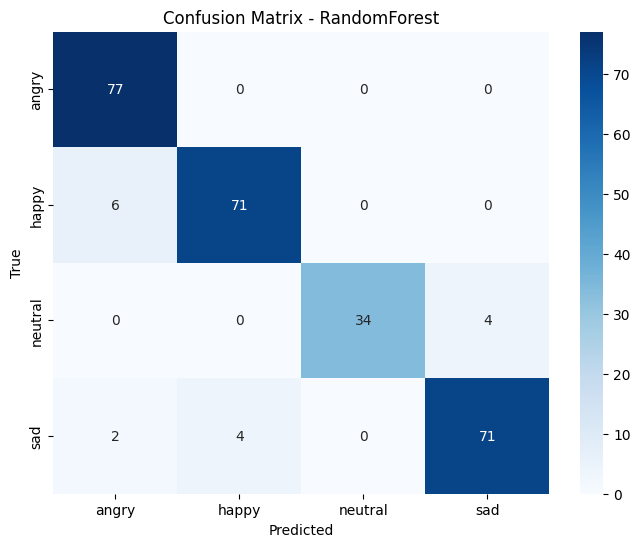

Building CNN dataset (mel-spectrogram images)...


100%|██████████| 1344/1344 [00:03<00:00, 395.15it/s]


CNN dataset shapes: (400, 128, 128, 1) (400,)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 batch_normaliz

c:\Users\nachi\anaconda3\envs\tf-gpu-cuda9\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nachi\anaconda3\envs\tf-gpu-cuda9\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nachi\anaconda3\envs\tf-gpu-cuda9\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


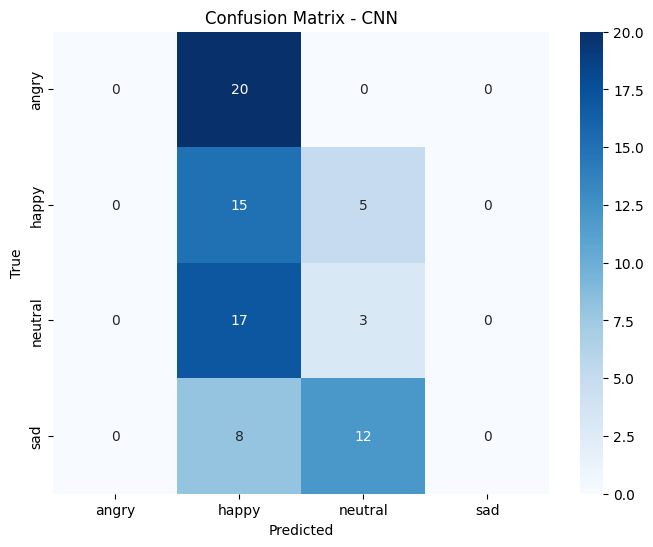

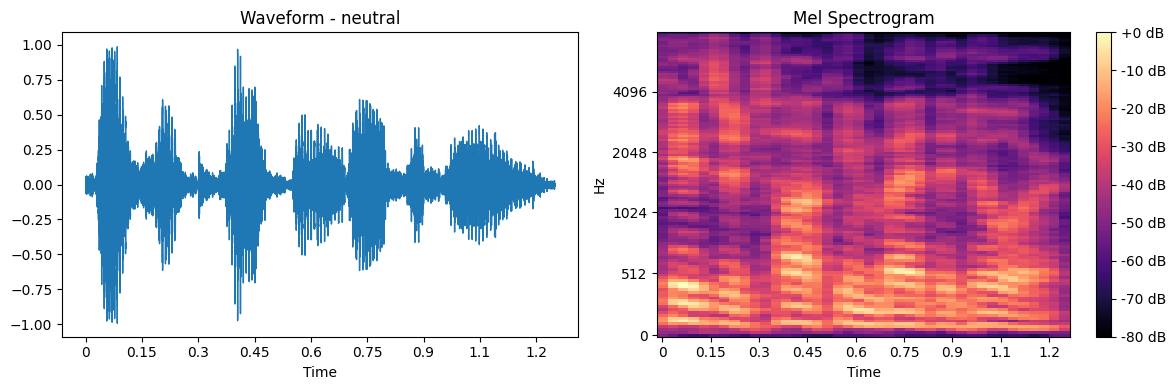

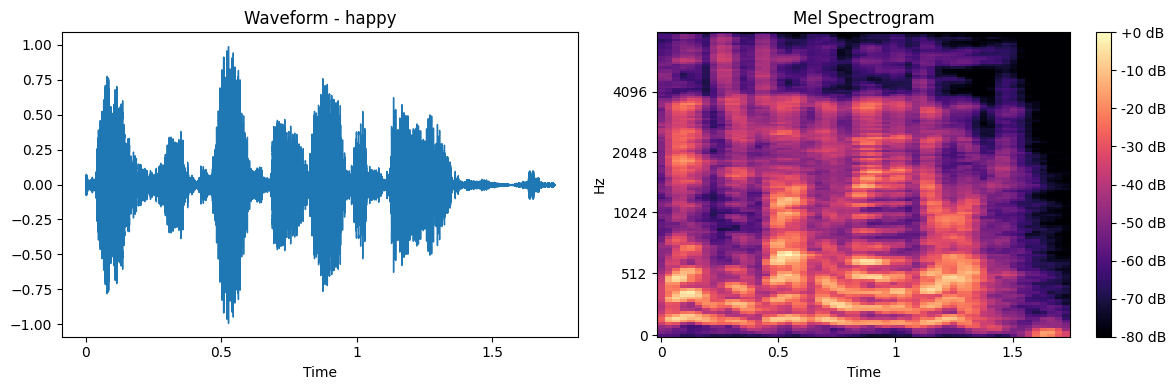

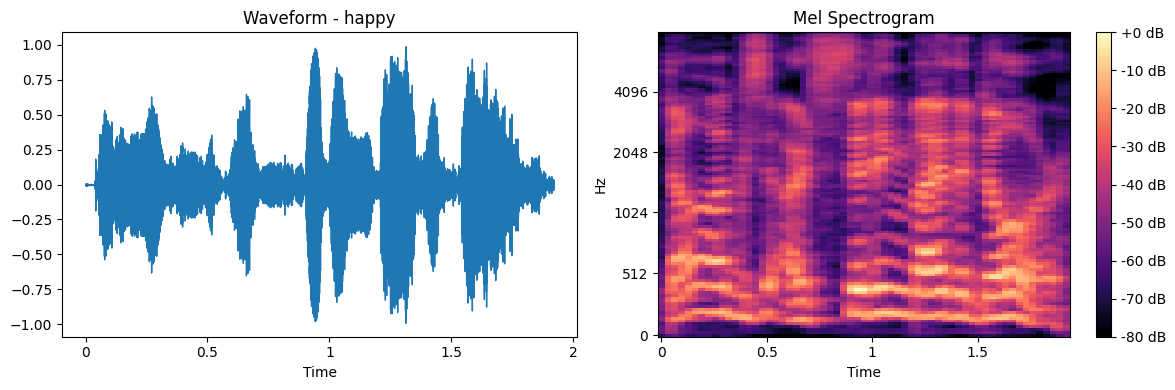

Saved cnn_mel_model.h5


(RandomForestClassifier(n_estimators=200, random_state=42),
 StandardScaler(),
 LabelEncoder(),
 LabelEncoder())

In [26]:
workflow()